# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 본인의 구글 드라이브에 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Argumentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)


## 1.환경설정 

### (1) 데이터셋 폴더 생성
- **세부요구사항**
    - C드라이브에 Datasets라는 폴더를 만드세요.
        - 구글드라이브를 사용하는경우 드라이브 첫 화면에 Datasets 라는 폴더를 만드세요. ('/content/drive/MyDrive/Datasets/')
    - 해당 폴더 안에 Car_Images.zip 파일을 넣으세요.

* 구글 Colab을 이용하는 경우

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !mkdir '/content/drive/MyDrive/Datasets/'

### (2) 데이터셋 불러오기 
- **세부요구사항**
    - Car_Images.zip 파일을 C:/Datasets/ 경로에 압축 해제합니다.
    - zipfile 모듈을 이용하거나 다른 방식을 사용해도 됩니다.
        - 참고 자료 : [zipfile document](https://docs.python.org/3/library/zipfile.html#zipfile-objects)
    - 폴더구조(로컬)
        * C:/Datasets/ : 압축파일
        * C:/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 폴더구조(구글드라이브브)
        * /content/drive/MyDrive/Datasets/ : 압축파일
        * /content/drive/MyDrive/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 압축을 해제하면 다음과 같은 두 하위 폴더가 생성됩니다.
        * normal, abnormal : 각 폴더에는 이미지들이 있습니다.
        * 이후 단계에서 해당 경로로 부터 validation, test 셋을 추출하게 됩니다.
        

In [3]:
import zipfile

In [4]:
# 압축파일 경로
# 구글 드라이브인 경우 경로에 맞게 지정하세요.
dataset_path  = '/content/drive/MyDrive/Datasets/'
# dataset_path = 'C:/Datasets/'

file_path = dataset_path + 'Car_Images.zip'

In [5]:
# # 압축 해제
data = zipfile.ZipFile(file_path)
data.extractall('/content/drive/MyDrive/Datasets/Car_Images_train/')

KeyboardInterrupt: ignored

### (3) 이미지 저장을 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 을 위해 각각 하위 폴더 normal과 abnormal를 준비합니다.
        - train
            * 정상 이미지 저장소 : C:/Datasets/Car_Images_train/normal/ 
                * 구글드라이브 :   /content/drive/MyDrive/Datasets/Car_Images_train/normal/
            * 파손 이미지 저장소 : C:/Datasets/Car_Images_train/abnormal/
                * 구글드라이브 : /content/drive/MyDrive/Datasets/Car_Images_train/abnormal/
        - val, test 역시 동일한 구조로 생성합니다.
    - 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
        - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [ ]:
import splitfolders

# 데이터 경로 설정
input_folder = '/content/drive/MyDrive/Datasets/Car_Images_train/'  # 분할할 원본 폴더 경로
output_folder = '/content/drive/MyDrive/Datasets/'  # 분할된 데이터 폴더 경로

# 데이터 분할 비율 설정
split_ratio = (0.64, 0.16, 0.2)  # train : validation : test

# 데이터 분할 수행
splitfolders.ratio(input_folder, output_folder, ratio=split_ratio, seed=42)

Copying files: 605 files [00:24, 24.34 files/s]


In [ ]:
import os
os.rename(os.path.join(output_folder, 'train'), os.path.join(output_folder, 'car_train'))
os.rename(os.path.join(output_folder, 'val'), os.path.join(output_folder, 'car_val'))
os.rename(os.path.join(output_folder, 'test'), os.path.join(output_folder, 'car_test'))

## 2.데이터 전처리

### (1) 데이터 분할 : Training set | Validation set | Test set 생성
- **세부요구사항**
    - Training set, Validation set, Test set을 만듭니다.
        * size
            * test : 전체에서 20%를 추출합니다.
            * validation : test를 떼어낸 나머지에서 다시 20%를 추출합니다.
        * 데이터는 랜덤하게 추출해야 합니다.
            - random, shutil 모듈을 이용하여 랜덤하게 추출할 수 있습니다.
                - [random document](https://docs.python.org/3/library/random.html) | [shutil document](https://docs.python.org/3/library/shutil.html)
            * 해당 모듈 이외에 자신이 잘 알고 있는 방법을 사용해도 됩니다.
---

#### 1) test, validation 크기를 지정

In [ ]:
import random, shutil

In [ ]:
# 전체 이미지 갯수를 확인합니다.
len(os.listdir('/content/drive/MyDrive/Datasets/car_train/abnormal'))

193

In [ ]:
len(os.listdir('/content/drive/MyDrive/Datasets/car_val/abnormal'))

48

In [ ]:
len(os.listdir('/content/drive/MyDrive/Datasets/car_test/abnormal'))

62

In [ ]:
# # test 사이즈 : 전체 이미지의 20%
# te_data_num = [round(len(os.listdir(tr_n_path))*0.2), round(len(os.listdir(tr_ab_path))*0.2)]
# print(te_data_num)

# # validation 사이즈 : test를 제외한 나머지 중에서 20%
# val_data_num = [ round((len(os.listdir(tr_n_path))-te_data_num[0])*0.2) , round((len(os.listdir(tr_n_path))-te_data_num[1])*0.2) ]
# print(val_data_num)

# # train 사이즈
# train_data_num = [len(os.listdir(tr_n_path)) - te_data_num[0] - val_data_num[0],
#                   len(os.listdir(tr_ab_path))- te_data_num[1] - val_data_num[1]]

#### 2) test 셋 추출

In [ ]:
random.seed(2023)









In [ ]:
# 추출 후 이미지 갯수 확인




#### 3) validation 셋 추출

In [ ]:
random.seed(2023)







In [ ]:
# 추출 후 이미지 갯수 확인




### (2) 데이터 복사 및 이동
- **세부요구사항**
    - 분할된 데이터를 복사 이동합니다.
        - 새로운 폴더에 저장하는 데이터로 "3.모델링I"에서 사용합니다.
        - 기존 폴더는 "4.모델링II > (1) Data Augmentation"에서 사용합니다.
    - Training set | Validation set | Test set의 데이터를 **새로운 폴더**에 복사하세요.
        - 새로운 폴더 명
            * copy_images/trainset
            * copy_images/validset
            * copy_images/testset
        - 새로운 폴더에는 normal, abnormal 파일 모두를 복사합니다. 
            * 파일을 구분하기 위해 abnormal 파일들은 파일명 앞에 접두사 'ab_'를 붙입시다.
        - os, shutil 모듈을 활용하세요.

#### 1) abnormal 파일 복사

* 복사하기 : shutil.copytree()

In [ ]:
!mkdir '/content/drive/MyDrive/Datasets_copy/'

mkdir: cannot create directory ‘/content/drive/MyDrive/Datasets_copy/’: File exists


In [ ]:
import os
import shutil

# 복사할 파일 경로와 복사될 경로 지정
src_file_path = '/content/drive/MyDrive/Datasets/car_train/'  # 복사할 파일 경로
dst_file_path = '/content/drive/MyDrive/Datasets_copy/car_train/'  # 복사될 파일 경로

# 파일 복사 수행
shutil.copytree(src_file_path, dst_file_path)

FileExistsError: ignored

In [ ]:
src_file_path = '/content/drive/MyDrive/Datasets/car_test/'  # 복사할 파일 경로
dst_file_path = '/content/drive/MyDrive/Datasets_copy/car_test/'  # 복사될 파일 경로

# 파일 복사 수행
shutil.copytree(src_file_path, dst_file_path)

In [ ]:
src_file_path = '/content/drive/MyDrive/Datasets/car_val/'  # 복사할 파일 경로
dst_file_path = '/content/drive/MyDrive/Datasets_copy/car_val/'  # 복사될 파일 경로

# 파일 복사 수행
shutil.copytree(src_file_path, dst_file_path)

* abnormal 이미지 이름의 접두어 "ab_" 붙이기 : os.rename

In [ ]:
import os

data_dir = "/content/drive/MyDrive/Datasets_copy/"
subdirs = ["car_train", "car_val", "car_test"]
subdir2 = 'abnormal'

for subdir in subdirs:
  subdir_path = os.path.join(data_dir, subdir, subdir2)
  for file_name in os.listdir(subdir_path):
        if file_name.endswith(".jpg") or file_name.endswith(".jpeg") or file_name.endswith(".png"):
            src_path = os.path.join(subdir_path, file_name)
            dst_path = os.path.join(subdir_path, 'ab_'+file_name)
            os.rename(src_path, dst_path)

#### 2) normal 파일 복사

* 데이터 갯수 조회

In [ ]:
# print(len(os.listdir(dataset_path+'copy_images/trainset/')))
# print(len(os.listdir(dataset_path+'copy_images/validset/')))
# print(len(os.listdir(dataset_path+'copy_images/testset/')))

## 3.모델링 I
* **세부요구사항**
    * 모델링을 위한 데이터 구조 만들기
        * x : 이미지를 array로 변환합니다.
        * y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

### (1) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다. 
    * 이미지 파일을 불러와 train, valid, test 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

#### 1) 이미지 목록 만들기
* train, validation, test 폴더로 부터 이미지 목록을 생성합니다.

In [ ]:
# 이미지 목록 저장
img_train_list = os.listdir('/content/drive/MyDrive/Datasets_copy/car_train')
img_valid_list = os.listdir('/content/drive/MyDrive/Datasets_copy/car_val')
img_test_list = os.listdir('/content/drive/MyDrive/Datasets_copy/car_test')

In [ ]:
# 메모리, 처리시간을 위해서 이미지 크기 조정
img_size = 280 ## 사이즈 조정 가능

#### 2) 이미지들을 배열 데이터셋으로 만들기

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data_dir = '/content/drive/MyDrive/Datasets_copy'
# img_size=280

# datagen = ImageDataGenerator(rescale=1./255)

# train_ds = datagen.flow_from_directory(
#     data_dir+'/car_train',
#     target_size=(img_size, img_size),
#     class_mode='binary'
# )

# val_ds = datagen.flow_from_directory(
#     data_dir+'/car_val',
#     target_size=(img_size, img_size),
#     class_mode='binary'
# )

# test_ds = datagen.flow_from_directory(
#     data_dir+'/car_test',
#     target_size=(img_size, img_size),
#     class_mode='binary'
# )

# print("Train dataset:", train_ds)
# print("Validation dataset:", val_ds)
# print("Test dataset:", test_ds)

Found 386 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 123 images belonging to 2 classes.
Train dataset: <keras.preprocessing.image.DirectoryIterator object at 0x7fbf70ff5880>
Validation dataset: <keras.preprocessing.image.DirectoryIterator object at 0x7fbf7100e430>
Test dataset: <keras.preprocessing.image.DirectoryIterator object at 0x7fbf7100eca0>


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image

img_path = '/content/drive/MyDrive/Datasets_copy/car_test/abnormal/ab_DALLíñE 2023-03-10 18.51.32 - scratched car.png'  # 이미지 파일 경로
image = Image.open(img_path)  # 이미지 열기
image.show()

Output hidden; open in https://colab.research.google.com to view.

### (2) y : 클래스 만들기
- **세부요구사항**
    - Training set / Validation set / Test set의 y를 생성합니다.
        - 각각 normal, abnormal 데이터의 갯수를 다시 확인하고
        - normal을 0, abnormal을 1로 지정합니다.

In [ ]:
# # 데이터 갯수 확인
# print( len(img_train_list) )
# print( len([val for val in img_train_list if val.startswith('ab_')]) )
# print('---')
# print( len(img_valid_list) )
# print( len([val for val in img_valid_list if val.startswith('ab_')]) )
# print('---')
# print( len(img_test_list) )
# print( len([val for val in img_test_list if val.startswith('ab_')]) )

* y_train, y_valid, y_test 만들기
    * normal, abnormal 데이터의 갯수를 다시 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 데이터셋 생성을 위한 빈 리스트 생성
X_train = []
y_train = []

# train 폴더 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_train/abnormal'):
    y_train.append(1)
       
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_train/abnormal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_train.append(img_array)

for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_train/normal'):
    y_train.append(0)
        
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_train/normal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_train.append(img_array)
    

# # 리스트를 np.array로 변환
X_train = np.concatenate(X_train, axis=0)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(386, 280, 280, 3)
(386,)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 데이터셋 생성을 위한 빈 리스트 생성
X_val = []
y_val = []

# train 폴더 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_val/abnormal'):
    if filename.startswith('ab'):  # abnormal 이미지인 경우
        y_val.append(1)
    else:  # normal 이미지인 경우
        y_val.append(0)
        
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_val/abnormal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_val.append(img_array)


for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_val/normal'):
    if filename.startswith('ab'):  # abnormal 이미지인 경우
        y_val.append(1)
    else:  # normal 이미지인 경우
        y_val.append(0)
        
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_val/normal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_val.append(img_array)
    
# 리스트를 np.array로 변환
X_val = np.concatenate(X_val, axis=0)
y_val = np.array(y_val)

print(X_val.shape)
print(y_val.shape)

(96, 280, 280, 3)
(96,)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 데이터셋 생성을 위한 빈 리스트 생성
X_test = []
y_test = []

# train 폴더 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_test/abnormal'):
    if filename.startswith('ab'):  # abnormal 이미지인 경우
        y_test.append(1)
    else:  # normal 이미지인 경우
        y_test.append(0)
        
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_test/abnormal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_test.append(img_array)


for filename in os.listdir('/content/drive/MyDrive/Datasets_copy/car_test/normal'):
    if filename.startswith('ab'):  # abnormal 이미지인 경우
        y_test.append(1)
    else:  # normal 이미지인 경우
        y_test.append(0)
        
    # 이미지 파일을 로딩하여 array로 변환하고 크기를 조정
    img = load_img(os.path.join('/content/drive/MyDrive/Datasets_copy/car_test/normal', filename), target_size=(280, 280))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch 차원 추가
    
    # 데이터셋에 이미지 배열과 레이블 추가
    X_test.append(img_array)
    
# 리스트를 np.array로 변환
X_test = np.concatenate(X_test, axis=0)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(123, 280, 280, 3)
(123,)


### (3) 모델1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(Input(shape=(280,280,3)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 280, 280, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 140, 140, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 140, 140, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 140, 140, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 70, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 70, 70, 128)       0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=1000,batch_size=12 ,callbacks=[es])

Epoch 1/1000
33/33 [==============================] - 9s 146ms/step - loss: 46.7752 - accuracy: 0.4741 - val_loss: 0.6907 - val_accuracy: 0.6771
Epoch 2/1000
33/33 [==============================] - 4s 129ms/step - loss: 0.6986 - accuracy: 0.5155 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 3/1000
33/33 [==============================] - 4s 132ms/step - loss: 0.6844 - accuracy: 0.5518 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 4/1000
33/33 [==============================] - 4s 134ms/step - loss: 0.6934 - accuracy: 0.5285 - val_loss: 0.6921 - val_accuracy: 0.5521
Epoch 5/1000
33/33 [==============================] - 4s 130ms/step - loss: 0.6956 - accuracy: 0.5155 - val_loss: 0.6872 - val_accuracy: 0.5312
Epoch 6/1000
33/33 [==============================] - 5s 137ms/step - loss: 0.6871 - accuracy: 0.6451 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 7/1000
33/33 [==============================] - 4s 129ms/step - loss: 0.6839 - accuracy: 0.5466 - val_loss: 0.6880 - val_accuracy

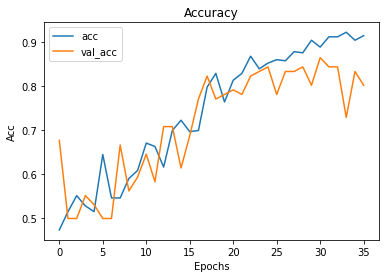

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'])
plt.show() 

In [ ]:
from sklearn.metrics import *
pred = model.predict(X_test)

4/4 [==============================] - 1s 84ms/step


In [ ]:
y_pred = []
for i in pred:
  if i >=0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
y_pred = np.array(y_pred)

In [ ]:
y_pred

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[51 10]
 [16 46]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        61
           1       0.82      0.74      0.78        62

    accuracy                           0.79       123
   macro avg       0.79      0.79      0.79       123
weighted avg       0.79      0.79      0.79       123



#### 2) 학습
* EarlyStopping 설정하고 학습시키기

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

### (4) 모델2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

### (5) 모델3
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
            - ImageDataGenerator를 사용합니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.
            - VGG16(이미지넷)을 사용해 봅시다.

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * image generator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_size = 280 ## 사이즈 조정 가능

train_path = dataset_path+'Car_Images_train/'
valid_path = dataset_path+'Car_Images_valid/'

NameError: ignored

#### 1) ImageGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 파라미터 설정
train_datagen = ImageDataGenerator(
        rescale=1./255,  # 이미지 스케일링
        rotation_range=20,  # 회전
        width_shift_range=0.2,  # 가로 이동
        height_shift_range=0.2,  # 세로 이동
        shear_range=0.2,  # 전단 변환
        zoom_range=0.2,  # 확대/축소
        horizontal_flip=True,  # 좌우 반전
        fill_mode='nearest'  # 경계 영역 채우기
)

#### 2) 경로로 부터 이미지 불러 올 준비
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고, 
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


In [ ]:
data_dir1 = '/content/drive/MyDrive/Datasets_copy/car_train'
data_dir2 = '/content/drive/MyDrive/Datasets_copy/car_val'
batch_size=16

train_generator = train_datagen.flow_from_directory(
    data_dir1,
    target_size=(280, 280),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

valid_generator = datagen.flow_from_directory(
    data_dir2,
    target_size=(280, 280),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 386 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Datasets_copy/car_train/abnormal')))
print(len(os.listdir('/content/drive/MyDrive/Datasets_copy/car_train/normal')))
print(len(train_generator.filenames))

193
193
386


#### 3) 학습
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 train_generator 이용. 
    - validation_data = valid_generator 지정
    - Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

* 구조 설계

In [ ]:
model.fit(train_generator, validation_data=valid_generator, epochs=1000,
          batch_size=16, callbacks=[es], verbose=1)

/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/1000
13/13 [==============================] - 48s 2s/step - loss: 0.7031 - accuracy: 0.4819 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/1000
13/13 [==============================] - 39s 3s/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 3/1000
13/13 [==============================] - 29s 2s/step - loss: 0.6888 - accuracy: 0.5492 - val_loss: 0.6768 - val_accuracy: 0.6979
Epoch 4/1000
13/13 [==============================] - 26s 2s/step - loss: 0.6709 - accuracy: 0.6399 - val_loss: 0.6414 - val_accuracy: 0.7083
Epoch 5/1000
13/13 [==============================] - 26s 2s/step - loss: 0.5815 - accuracy: 0.7306 - val_loss: 0.5666 - val_accuracy: 0.7188
Epoch 6/1000
13/13 [==============================] - 26s 2s/step - loss: 0.5897 - accuracy: 0.7098 - val_loss: 0.5687 - val_accuracy: 0.7188
Epoch 7/1000
13/13 [==============================] - 26s 2s/step - loss: 0.5513 - accuracy: 0.7617 - val_loss: 0.4946 - val_accuracy: 0.7500
Epoch 

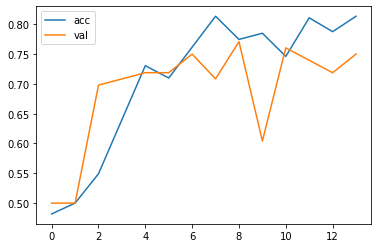

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['acc','val'])
plt.show()

In [ ]:
pred = model.predict(X_test)

y_pred = np.where(pred>0.5, 1, 0).flatten()

from sklearn.metrics import *

print(classification_report(y_test, y_pred))

4/4 [==============================] - 0s 62ms/step
              precision    recall  f1-score   support

           0       0.14      0.02      0.03        61
           1       0.48      0.90      0.63        62

    accuracy                           0.46       123
   macro avg       0.31      0.46      0.33       123
weighted avg       0.31      0.46      0.33       123



In [ ]:
pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

* 학습
    * EarlyStopping 설정하기
    * 학습 데이터에 train_generator, validation_data=valid_generator 사용

#### 4) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다. 
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# VGG16 모델 가져오기
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(280, 280, 3))

# 입력층 정의하기
input_tensor = Input(shape=(280, 280, 3))

# VGG16 모델에 입력층 적용하기
x = vgg16(input_tensor)

# 추가적인 층 쌓기
x = Flatten()(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)

# 새로운 모델 정의하기
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# 모델 구조 출력하기
model.summary()

# 모든 레이어 trainable 설정하기
for layer in model.layers:
    layer.trainable = True

# 모델 컴파일하기
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 14,747,457
Trainable params: 14,747,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000,
          batch_size=16, callbacks=[es], verbose=1)

Epoch 1/1000
25/25 [==============================] - 20s 380ms/step - loss: 17.7620 - accuracy: 0.4793 - val_loss: 0.7094 - val_accuracy: 0.5000
Epoch 2/1000
25/25 [==============================] - 10s 382ms/step - loss: 0.7159 - accuracy: 0.5648 - val_loss: 0.6963 - val_accuracy: 0.5208
Epoch 3/1000
25/25 [==============================] - 9s 348ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/1000
25/25 [==============================] - 9s 342ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/1000
25/25 [==============================] - 8s 337ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/1000
25/25 [==============================] - 8s 336ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/1000
25/25 [==============================] - 8s 337ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accura

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# 사전 학습된 VGG16 모델을 불러옵니다.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(280, 280, 3))

# 모델 구조를 확인합니다.
base_model.summary()

# 사전 학습된 가중치를 동결합니다.
for layer in base_model.layers:
    layer.trainable = False

# 모델 구조를 새롭게 정의합니다.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

# 새로운 모델을 정의합니다.
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 모델 구조를 확인합니다.
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 70, 70, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000,
          batch_size=16, callbacks=[es], verbose=1)

Epoch 1/1000
25/25 [==============================] - 4s 158ms/step - loss: 30.0565 - accuracy: 0.2435 - val_loss: 16.3455 - val_accuracy: 0.1354
Epoch 2/1000
25/25 [==============================] - 4s 166ms/step - loss: 14.2077 - accuracy: 0.2617 - val_loss: 9.3721 - val_accuracy: 0.1771
Epoch 3/1000
25/25 [==============================] - 4s 169ms/step - loss: 7.9800 - accuracy: 0.2565 - val_loss: 4.7221 - val_accuracy: 0.3333
Epoch 4/1000
25/25 [==============================] - 4s 142ms/step - loss: 3.8381 - accuracy: 0.4585 - val_loss: 2.2765 - val_accuracy: 0.5417
Epoch 5/1000
25/25 [==============================] - 4s 168ms/step - loss: 1.9766 - accuracy: 0.6140 - val_loss: 1.1774 - val_accuracy: 0.6979
Epoch 6/1000
25/25 [==============================] - 4s 144ms/step - loss: 1.2064 - accuracy: 0.7047 - val_loss: 0.8156 - val_accuracy: 0.7604
Epoch 7/1000
25/25 [==============================] - 3s 140ms/step - loss: 0.7858 - accuracy: 0.8005 - val_loss: 0.6481 - val_accura

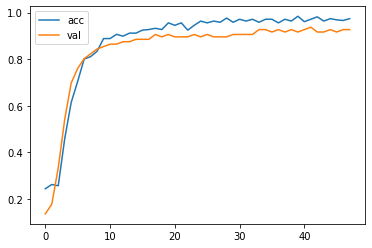

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['acc','val'])
plt.show()

In [ ]:
pred = model.predict(X_test)

4/4 [==============================] - 1s 215ms/step


In [ ]:
y_pred = np.where(pred>0.5, 1, 0).flatten()

In [ ]:
from sklearn.metrics import *
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        61
           1       1.00      0.90      0.95        62

    accuracy                           0.95       123
   macro avg       0.96      0.95      0.95       123
weighted avg       0.96      0.95      0.95       123



* 증강 데이터

In [ ]:
model.fit(train_generator, validation_data=valid_generator, epochs=1000,
          batch_size=16, callbacks=[es], verbose=1)

Epoch 1/1000
25/25 [==============================] - 30s 1s/step - loss: 0.7469 - accuracy: 0.4896 - val_loss: 0.7192 - val_accuracy: 0.4583
Epoch 2/1000
25/25 [==============================] - 25s 1s/step - loss: 0.7284 - accuracy: 0.4508 - val_loss: 0.6976 - val_accuracy: 0.5312
Epoch 3/1000
25/25 [==============================] - 25s 1s/step - loss: 0.7274 - accuracy: 0.4534 - val_loss: 0.6847 - val_accuracy: 0.6146
Epoch 4/1000
25/25 [==============================] - 27s 1s/step - loss: 0.7110 - accuracy: 0.4948 - val_loss: 0.6872 - val_accuracy: 0.5833
Epoch 5/1000
25/25 [==============================] - 30s 1s/step - loss: 0.7069 - accuracy: 0.5078 - val_loss: 0.6692 - val_accuracy: 0.6146
Epoch 6/1000
25/25 [==============================] - 25s 1s/step - loss: 0.6985 - accuracy: 0.5492 - val_loss: 0.6614 - val_accuracy: 0.6562
Epoch 7/1000
25/25 [==============================] - 25s 1s/step - loss: 0.6998 - accuracy: 0.5207 - val_loss: 0.6517 - val_accuracy: 0.7292
Epoch 

In [ ]:
pred = model.predict(X_test)
y_pred = np.where(pred>0.5, 1, 0).flatten()
from sklearn.metrics import *
print(classification_report(y_test, y_pred))

4/4 [==============================] - 1s 207ms/step
              precision    recall  f1-score   support

           0       0.62      0.08      0.14        61
           1       0.51      0.95      0.67        62

    accuracy                           0.52       123
   macro avg       0.57      0.52      0.41       123
weighted avg       0.57      0.52      0.41       123



#### EfficientNet사용

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(280,280,3))
    
# 출력 레이어 수정
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid', name='output')(x)

# 전체 모델 생성
model = Model(inputs=base_model.input, outputs=x)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 280, 280, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 280, 280, 3)  0           ['input_11[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 280, 280, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 280, 280, 3)  0           ['normalization[0][0]']    

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit(train_generator, validation_data=valid_generator, epochs=1000, callbacks=[es], verbose=1)

Epoch 1/1000
25/25 [==============================] - 74s 1s/step - loss: 0.2455 - accuracy: 0.8912 - val_loss: 0.8488 - val_accuracy: 0.5000
Epoch 2/1000
25/25 [==============================] - 26s 1s/step - loss: 0.2155 - accuracy: 0.9145 - val_loss: 1.5148 - val_accuracy: 0.5000
Epoch 3/1000
25/25 [==============================] - 27s 1s/step - loss: 0.1093 - accuracy: 0.9637 - val_loss: 1.6595 - val_accuracy: 0.5000
Epoch 4/1000
25/25 [==============================] - 26s 1s/step - loss: 0.1618 - accuracy: 0.9378 - val_loss: 0.6783 - val_accuracy: 0.5729
Epoch 5/1000
25/25 [==============================] - 26s 1s/step - loss: 0.1462 - accuracy: 0.9560 - val_loss: 0.8850 - val_accuracy: 0.5000
Epoch 6/1000
25/25 [==============================] - 26s 1s/step - loss: 0.0970 - accuracy: 0.9560 - val_loss: 1.2410 - val_accuracy: 0.5000
Epoch 7/1000
25/25 [==============================] - 26s 1s/step - loss: 0.1617 - accuracy: 0.9404 - val_loss: 0.9482 - val_accuracy: 0.5000
Epoch 

In [ ]:
pred = model.predict(X_test)
y_pred = np.where(pred>0.5, 1, 0).flatten()
from sklearn.metrics import *
print(classification_report(y_test, y_pred))

4/4 [==============================] - 3s 342ms/step
              precision    recall  f1-score   support

           0       0.33      0.38      0.35        61
           1       0.30      0.26      0.28        62

    accuracy                           0.32       123
   macro avg       0.31      0.32      0.31       123
weighted avg       0.31      0.32      0.31       123



#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 True로 설정하여 모델의 모든 레이어들이 fine-tuning에 대해 업데이트되도록 합니다.


In [ ]:
base_model = VGG16(                 )




#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [ ]:
# 전체 이미지 갯수를 확인합니다.
len(os.listdir('/content/drive/MyDrive/Datasets_copy/car_train/abnormal'))

193

In [ ]:
train_generator

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        * Image Generator를 연결하거나
        * 기존 train, validation 셋을 이용해도 됩니다.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

#### 4) 성능 평가